<a href="https://colab.research.google.com/github/eridanletalis/gb_cv/blob/main/CV8_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализовать синтезирование лиц из LFW с помощью DCGAN

В ходе экспериментов немного поменял сетку, увеличив число признаков для свёртки. Сделал около 81000 шагов, после 20к генератор выдаёт что-то похожее на фотографию человеческого лица

In [15]:
%tensorflow_version 2.x

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [17]:
train_ds, ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split='train'
)

In [18]:

train_ds

<PrefetchDataset shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [19]:
elem = train_ds.take(1)

for label, image in elem:
    print(image.shape, label)

(250, 250, 3) tf.Tensor(b'Tom_Amstutz', shape=(), dtype=string)


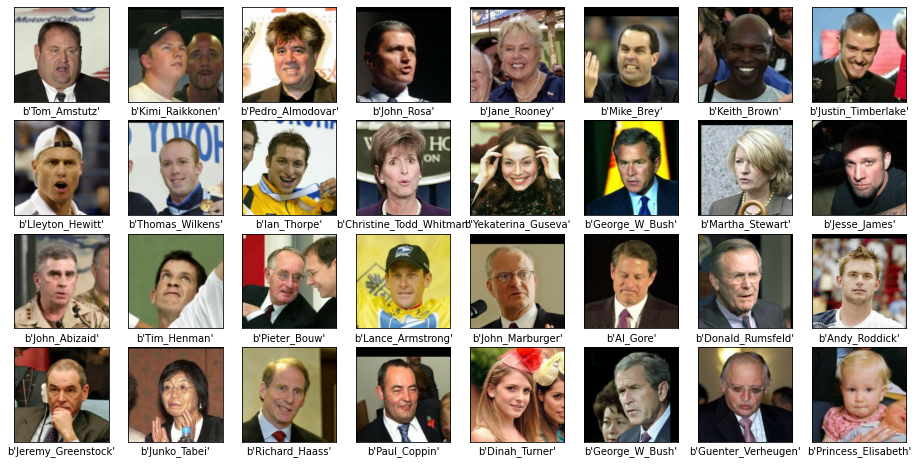

In [20]:
ds = train_ds.take(32)

fig = plt.figure(figsize=(16, 8))
j = 0
for label, image in tfds.as_numpy(ds):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.xlabel(str(label))
    j += 1
plt.show()

In [21]:
INP_SIZE = 128
NUM_EPOCHS = 100
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2

def prepare(label, img):
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5 # / 255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE))

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
# train_ds = train_ds.take(12800)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

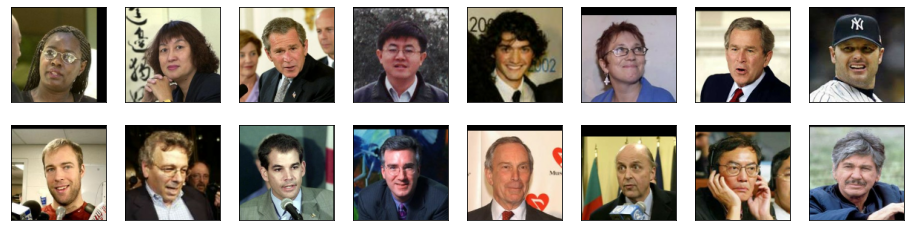

In [22]:
fig = plt.figure(figsize=(16, 4))
j = 0
for batch in tfds.as_numpy(train_ds.take(1)):
    for image in batch:
        ax = fig.add_subplot(2, 8, j+1)
        ax.imshow((image+1)/2.)
        plt.xticks([]), plt.yticks([])
        j += 1
plt.show()

In [24]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*32*32, activation='relu'),
    tf.keras.layers.Reshape((32, 32, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(512, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.82),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.82),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    # tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.29),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.27),
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.27),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [25]:

INPUT_DIM = 128
LEARNING_RATE = 0.0001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:

def plot_faces(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow((samples[j, ...].reshape(INP_SIZE, INP_SIZE, 3)+1)/2.)
        plt.xticks([]), plt.yticks([])
    plt.show()

In [23]:
len(train_ds)

82706

[Step   0] D Loss: 0.527579; G Loss: 0.613354


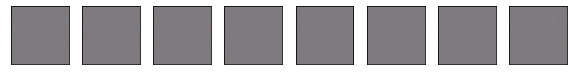

[Step 400] D Loss: 0.013255; G Loss: 0.002585


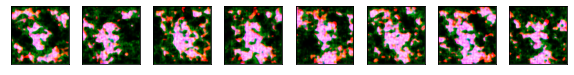

[Step 800] D Loss: 0.000137; G Loss: 0.002201


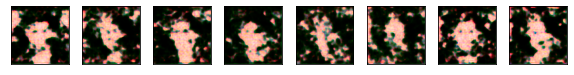

[Step 1200] D Loss: 0.199040; G Loss: 4.674394


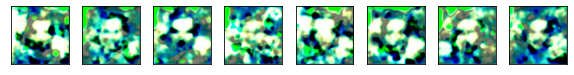

[Step 1600] D Loss: 0.144226; G Loss: 6.271104


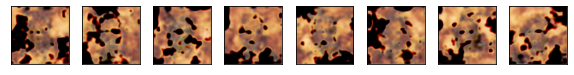

[Step 2000] D Loss: 1.488007; G Loss: 3.815353


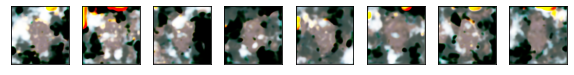

[Step 2400] D Loss: 0.287257; G Loss: 6.802249


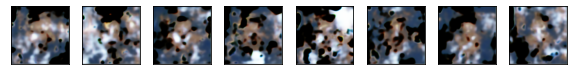

[Step 2800] D Loss: 0.282183; G Loss: 3.188938


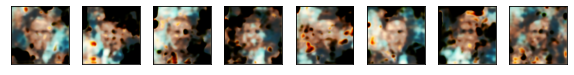

[Step 3200] D Loss: 0.057098; G Loss: 4.806579


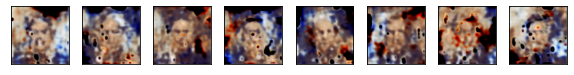

[Step 3600] D Loss: 0.336967; G Loss: 3.671833


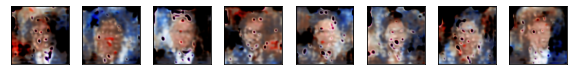

[Step 4000] D Loss: 0.600695; G Loss: 5.859934


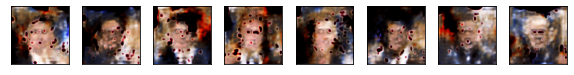

[Step 4400] D Loss: 0.593978; G Loss: 5.081831


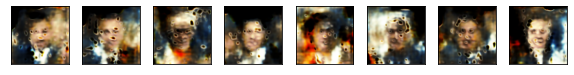

[Step 4800] D Loss: 0.094016; G Loss: 6.002851


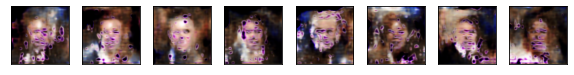

[Step 5200] D Loss: 0.416994; G Loss: 6.077880


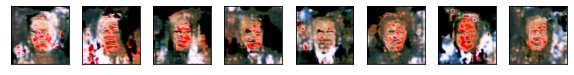

[Step 5600] D Loss: 0.263958; G Loss: 7.512742


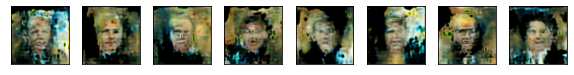

[Step 6000] D Loss: 0.151716; G Loss: 3.118748


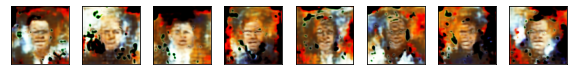

[Step 6400] D Loss: 0.757173; G Loss: 6.284955


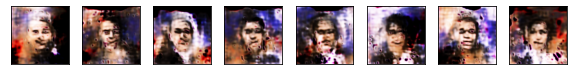

[Step 6800] D Loss: 0.769973; G Loss: 5.188890


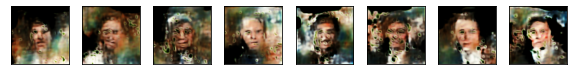

[Step 7200] D Loss: 0.560808; G Loss: 1.965755


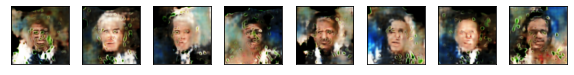

[Step 7600] D Loss: 0.452875; G Loss: 6.050767


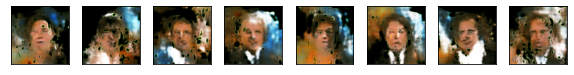

[Step 8000] D Loss: 0.212290; G Loss: 10.134608


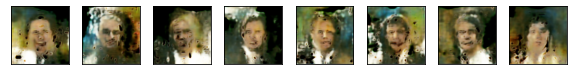

[Step 8400] D Loss: 0.736231; G Loss: 1.211245


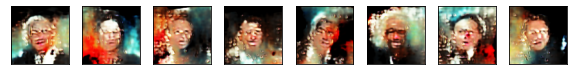

[Step 8800] D Loss: 0.266971; G Loss: 7.578551


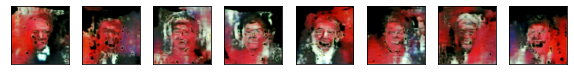

[Step 9200] D Loss: 0.241783; G Loss: 5.603388


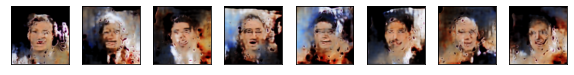

[Step 9600] D Loss: 0.659201; G Loss: 3.642313


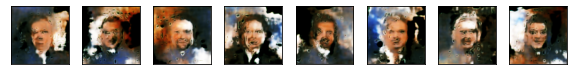

[Step 10000] D Loss: 0.033695; G Loss: 10.935807


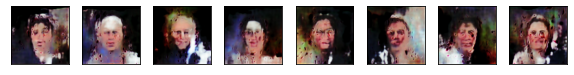

[Step 10400] D Loss: 0.549686; G Loss: 5.092765


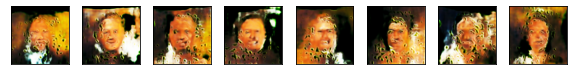

[Step 10800] D Loss: 0.150695; G Loss: 0.326771


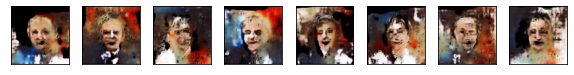

[Step 11200] D Loss: 0.196200; G Loss: 3.358762


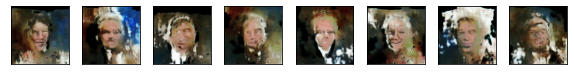

[Step 11600] D Loss: 0.192888; G Loss: 5.383211


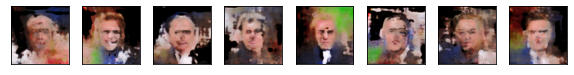

[Step 12000] D Loss: 0.005522; G Loss: 11.606410


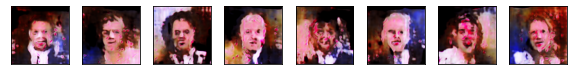

[Step 12400] D Loss: 0.400722; G Loss: 4.665109


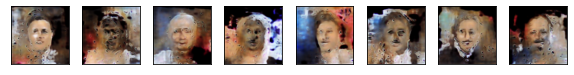

[Step 12800] D Loss: 0.312413; G Loss: 4.841653


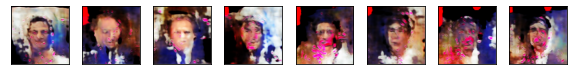

[Step 13200] D Loss: 0.589357; G Loss: 2.069583


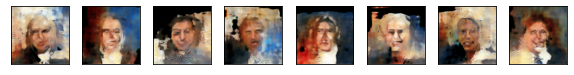

[Step 13600] D Loss: 0.329442; G Loss: 2.466563


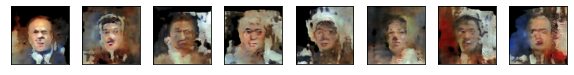

[Step 14000] D Loss: 1.180048; G Loss: 2.734336


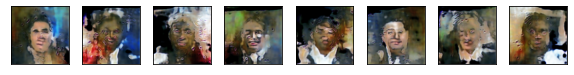

[Step 14400] D Loss: 0.161464; G Loss: 6.880354


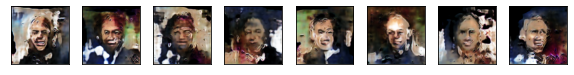

[Step 14800] D Loss: 0.125586; G Loss: 5.208547


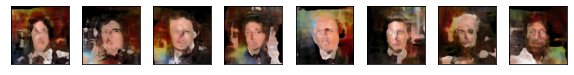

[Step 15200] D Loss: 0.128953; G Loss: 6.237778


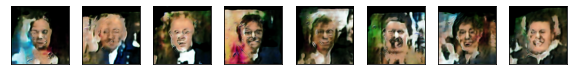

[Step 15600] D Loss: 0.300999; G Loss: 6.887047


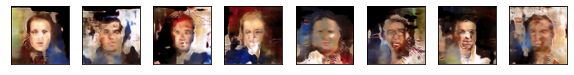

[Step 16000] D Loss: 0.265384; G Loss: 2.406292


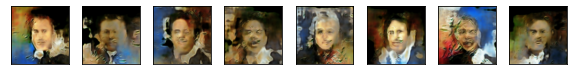

[Step 16400] D Loss: 0.528263; G Loss: 1.461648


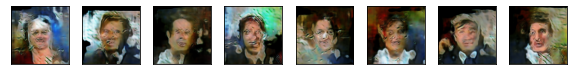

[Step 16800] D Loss: 0.410313; G Loss: 2.737862


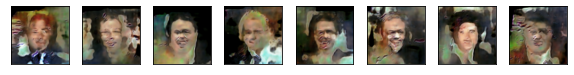

[Step 17200] D Loss: 0.103053; G Loss: 4.705218


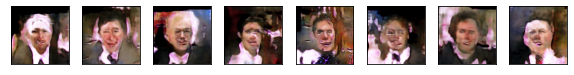

[Step 17600] D Loss: 0.130813; G Loss: 4.961535


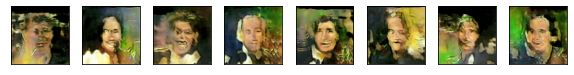

[Step 18000] D Loss: 0.432409; G Loss: 2.431341


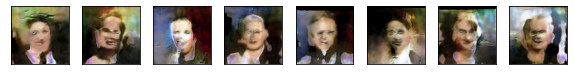

[Step 18400] D Loss: 0.312926; G Loss: 3.706208


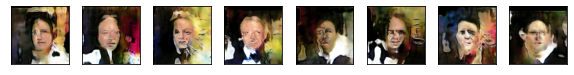

[Step 18800] D Loss: 0.324989; G Loss: 3.314096


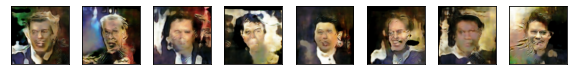

[Step 19200] D Loss: 0.263124; G Loss: 1.776054


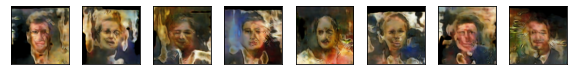

[Step 19600] D Loss: 1.383710; G Loss: 2.312184


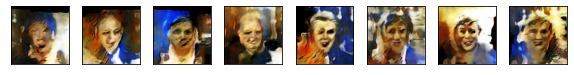

[Step 20000] D Loss: 0.907651; G Loss: 5.126980


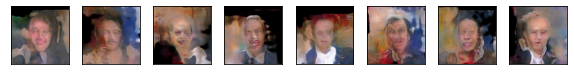

[Step 20400] D Loss: 0.404932; G Loss: 1.354716


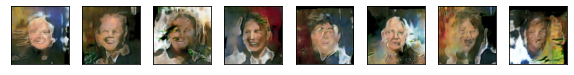

[Step 20800] D Loss: 0.358984; G Loss: 3.146486


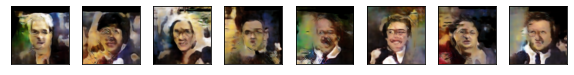

[Step 21200] D Loss: 0.261247; G Loss: 5.827817


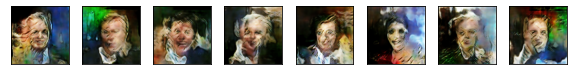

[Step 21600] D Loss: 0.266826; G Loss: 2.544664


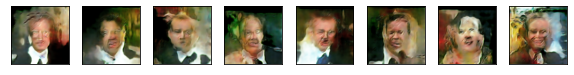

[Step 22000] D Loss: 0.448378; G Loss: 5.335830


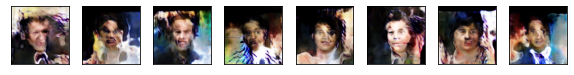

[Step 22400] D Loss: 0.887790; G Loss: 3.649651


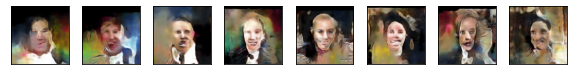

[Step 22800] D Loss: 1.634663; G Loss: 5.529175


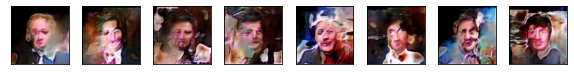

[Step 23200] D Loss: 0.721199; G Loss: 4.021383


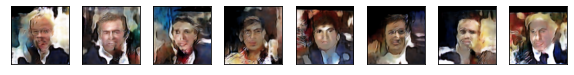

[Step 23600] D Loss: 0.143771; G Loss: 4.185309


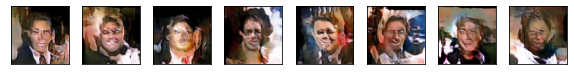

[Step 24000] D Loss: 0.349405; G Loss: 2.647910


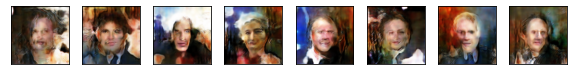

[Step 24400] D Loss: 0.680213; G Loss: 3.030784


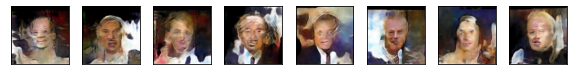

[Step 24800] D Loss: 0.159868; G Loss: 2.836894


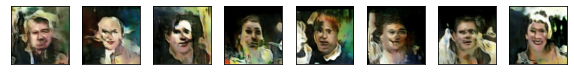

[Step 25200] D Loss: 0.314832; G Loss: 2.063480


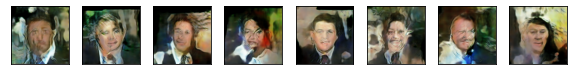

[Step 25600] D Loss: 0.538460; G Loss: 1.275810


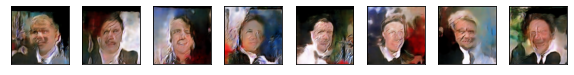

[Step 26000] D Loss: 0.251379; G Loss: 3.515554


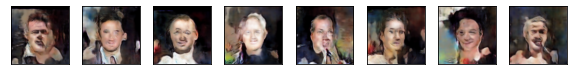

[Step 26400] D Loss: 0.214992; G Loss: 2.924478


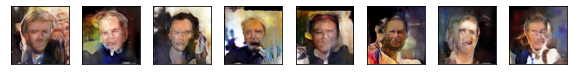

[Step 26800] D Loss: 0.814389; G Loss: 1.056078


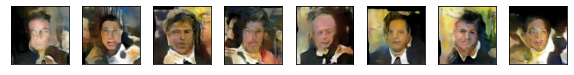

[Step 27200] D Loss: 0.412492; G Loss: 4.193627


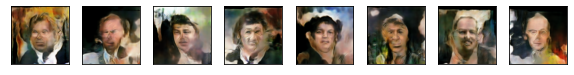

[Step 27600] D Loss: 0.719736; G Loss: 2.620615


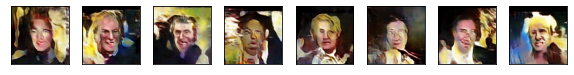

[Step 28000] D Loss: 0.067667; G Loss: 4.764351


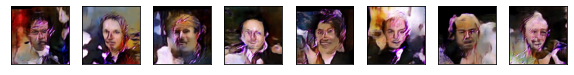

[Step 28400] D Loss: 0.287979; G Loss: 0.849305


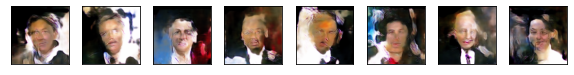

[Step 28800] D Loss: 0.134052; G Loss: 2.450563


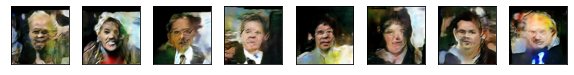

[Step 29200] D Loss: 0.217346; G Loss: 5.629392


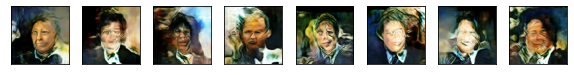

[Step 29600] D Loss: 1.063216; G Loss: 1.161479


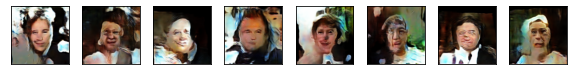

[Step 30000] D Loss: 0.267747; G Loss: 1.840032


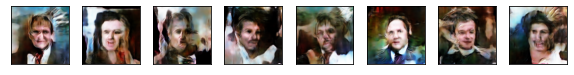

[Step 30400] D Loss: 0.425100; G Loss: 2.148514


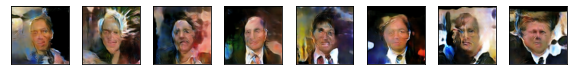

[Step 30800] D Loss: 0.421657; G Loss: 0.941140


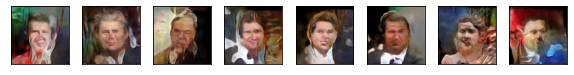

[Step 31200] D Loss: 0.378867; G Loss: 2.200207


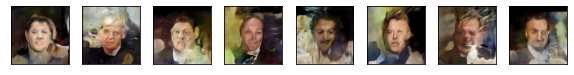

[Step 31600] D Loss: 0.414883; G Loss: 0.902113


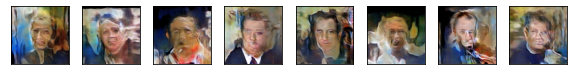

[Step 32000] D Loss: 0.347789; G Loss: 1.612677


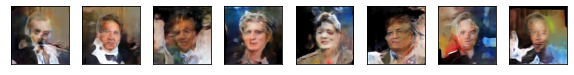

[Step 32400] D Loss: 0.518533; G Loss: 1.379380


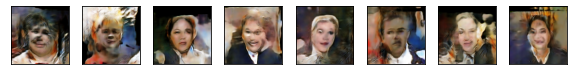

[Step 32800] D Loss: 0.460384; G Loss: 1.286351


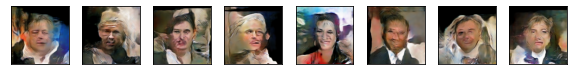

[Step 33200] D Loss: 0.204794; G Loss: 3.900087


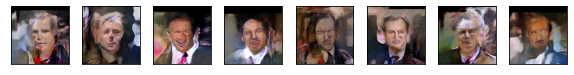

[Step 33600] D Loss: 0.518890; G Loss: 2.329868


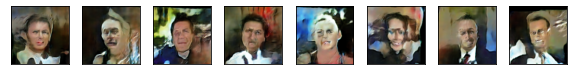

[Step 34000] D Loss: 0.414379; G Loss: 3.695462


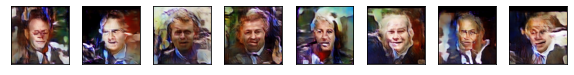

[Step 34400] D Loss: 0.338924; G Loss: 2.141733


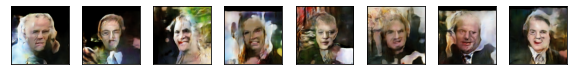

In [ ]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    # print(syntetic_images.shape, true_images.shape)
    # break
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 400 == 0:
        print('[Step %3d] D Loss: %.6f; G Loss: %.6f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_faces(syntetic_images)

In [ ]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)